<a href="https://colab.research.google.com/github/astroChance/MPnet/blob/master/MPnet_workbook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install --upgrade segyio

     |████████████████████████████████| 92kB 2.6MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import segyio
import time
import itertools
import os
import re
import random

In [5]:
### Data filenames

# 3D

Volume3D = "/content/drive/My Drive/MPnet/GAN data/3D/PB3D_Fritz_subset.sgy"

# 2D

TwoDFiles = []
for root, dirs, files in os.walk("/content/drive/My Drive/MPnet/GAN data/2D"):
    for name in files:
        filename = os.path.join(root, name)
        TwoDFiles.append(filename)
print("2D files in directory: ", len(TwoDFiles))

2D files in directory:  140


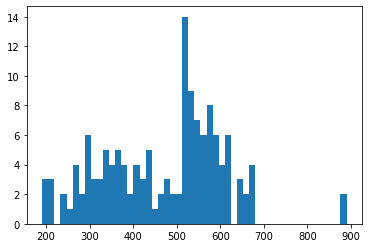

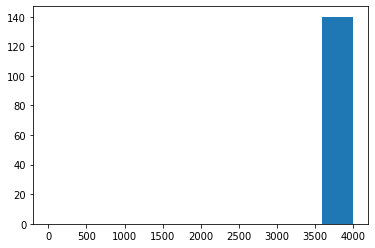

3600.0


In [14]:
### Data geometry check

Zero_Ax = []
One_Ax = []

for radar_line in TwoDFiles:
  with segyio.open(radar_line, 'r', ignore_geometry=True) as line:
    Line = segyio.tools.collect(line.trace[:])
    Zero_Ax.append(Line.shape[0])
    One_Ax.append(Line.shape[1])

plt.hist(Zero_Ax, bins=50)
plt.show()
plt.hist(One_Ax, range=[0,4000])
plt.show()

print(sum(One_Ax) / len(One_Ax))

In [ ]:
### Visual QC

# radar_file = TwoDFiles[0]
radar_file = random.choice(TwoDFiles)

with segyio.open(radar_file, 'r', ignore_geometry=True) as segyfile:
  display_line = segyio.tools.collect(segyfile.trace[:])

plt.figure(figsize=(15,5))
plt.imshow(display_line.T, cmap='seismic_r', vmin = -60, vmax = -20, aspect='auto')
